In [1]:
import random
import cv2
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

import keras
from keras import backend as K 
from keras.models import Sequential, Model
from keras.layers.core import Dense, Dropout, Flatten, Reshape, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras.utils import np_utils

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input, decode_predictions

%matplotlib inline

# Hide Warnings
# pd.options.mode.chained_assignment = None

# Set Seeds
tf.random.set_seed(42)
seed = 42
np.random.seed(42) # numpy seed (also used by keras)
random.seed(42)

# Intelligent Data Analysis 2 Project: EuroSAT

## Problem Setting

### Dataset

EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification (Vol. 12, Number 7, pp. 2217–2226). Zenodo. https://doi.org/10.5281/zenodo.7711810

EuroSAT is a land use and land cover classification dataset. 

The dataset is based on Sentinel-2 satellite imagery covering 13 spectral bands and consists of 10 LULC classes with a total of 27,000 labeled and geo-referenced images. The RGB version of the dataset includes the optical R, G and B frequency bands encoded as JPEG images. The multi-spectral version of the EuroSAT dataset includes all 13 Sentinel-2 bands in the original value range. This project uses the RGB version.

### Task

Train a neural network that predicts the right class label (y) of 10 available labels for a given input image of size 64 x 64 px with the Channels R, G and B (X).



### Learning Problem

Multiclass image classification (supervised)

## Explorative Data Analysis

In [2]:
ds, info = tfds.load('eurosat', split='all', data_dir='./data/eurosat', with_info=True)
assert isinstance(ds, tf.data.Dataset)
print(ds)

ds = tfds.as_numpy(ds)

images = []
labels = []

for image in ds:
    images.append(image['image'])
    labels.append(image['label'])
    
print(len(images))
print(len(labels))

images = np.array(images)
labels = np.array(labels)

<PrefetchDataset element_spec={'filename': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>
27000
27000


In [3]:
info.features

FeaturesDict({
    'filename': Text(shape=(), dtype=string),
    'image': Image(shape=(64, 64, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
})

In [4]:
# Labels
print("Number of Labels:", info.features["label"].num_classes)
print("Label Names:", info.features["label"].names)
# print(info.features["label"].int2str(7))  # Human readable version (8 -> 'cat')
# print(info.features["label"].str2int('AnnualCrop'))

Number of Labels: 10
Label Names: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


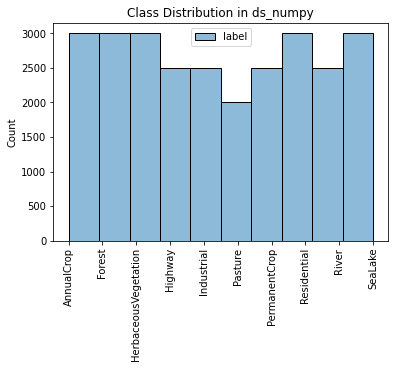

In [5]:
class_distribution = sns.histplot(ds, bins=10).set_title("Class Distribution in ds_numpy")
plt.xticks(ticks=range(0, 10), labels=info.features["label"].names, rotation=90)
plt.show()
# class_distribution.figure.savefig('report/figures/class_distribution.png', dpi=300, transparent=False, facecolor='white')

# Pasture - 2000
# Highway, Industrial, PermanentCrop, River - 2500
# AnnualCrop, Forest, HerbaceousVegetation, Residential, SeaLake - 3000

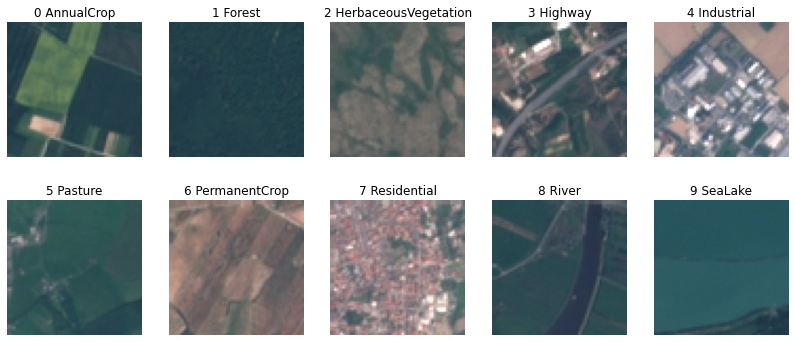

In [6]:
fig, axs = plt.subplots(2, 5, figsize=(14, 6))

label_id = 0
for x in range(0, 2):
        for y in range(0, 5):            
            for image, label in zip(images, labels):
                if (label == label_id):
                        axs[x, y].imshow(image)
                        axs[x, y].set_title(str(label) + " " + info.features["label"].int2str(label))
                        axs[x, y].axis('off')
                        label_id += 1
                        break

## Preprocessing

In [7]:
# train_test_split shuffles the data
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.20, random_state=seed)
# X_test, X_validation, y_test, y_validation = train_test_split(X_test, y_test, test_size=0.50, random_state=seed)

print(len(X_train))
print(len(X_test))
# print(len(X_validation))

21600
5400


In [8]:
# Data Augmentation of the training data set
X_train_augmented = []
y_train_augmented = []

for image, label in zip(X_train, y_train):
    break
    # flip (cautious)
    # not implemented
    
    # rotate
    # img_90 = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    # img_180 = cv2.rotate(image, cv2.ROTATE_180)
    # img_270 = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    
    # X_train_augmented.append(img_90)
    # X_train_augmented.append(img_180)
    # X_train_augmented.append(img_270)
    
    # y_train_augmented.append(label)
    # y_train_augmented.append(label)
    # y_train_augmented.append(label)

X_train_complete = np.array(list(X_train) + X_train_augmented)
print(len(X_train_complete))

y_train_complete = np.array(list(y_train) + y_train_augmented)
print(len(y_train_complete))

21600
21600


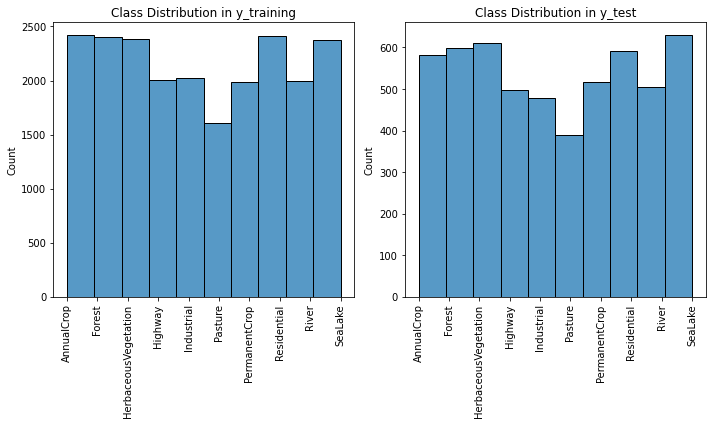

In [9]:
# Plot distribution of class labels in training and test set
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
sns.histplot(ax=axes[0], data=y_train_complete, bins=10)
axes[0].set_title("Class Distribution in y_training")
axes[0].set_xticks(ticks=range(0, 10), labels=info.features["label"].names, rotation=90)

sns.histplot(ax=axes[1], data=y_test, bins=10)
axes[1].set_title("Class Distribution in y_test")
axes[1].set_xticks(ticks=range(0, 10), labels=info.features["label"].names, rotation=90)

fig.tight_layout()

(x_train) min_val: 0 max_val: 255
(x_test) min_val: 0 max_val: 255


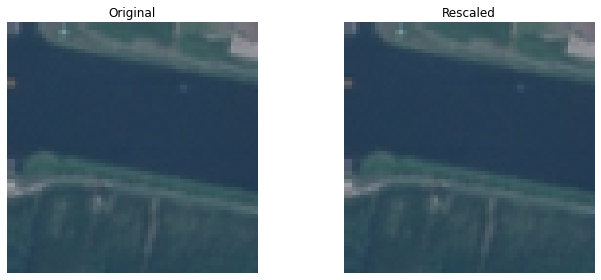

In [10]:
# normalize images
min_val = np.amin(X_train_complete)
max_val = np.amax(X_train_complete)
X_train_rescaled = (X_train_complete.astype(float) - min_val) / (max_val - min_val)
print("(x_train) min_val:", min_val, "max_val:", max_val)

min_val = np.amin(X_test)
max_val = np.amax(X_test)
X_test_rescaled = (X_test.astype(float) - min_val) / (max_val - min_val)
print("(x_test) min_val:", min_val, "max_val:", max_val)

# Print comparison of original and rescaled image
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axes[0].imshow(X_train_complete[0])
axes[0].title.set_text('Original')
axes[0].axis('off')

axes[1].imshow(X_train_rescaled[0])
axes[1].title.set_text('Rescaled')
axes[1].axis('off')

fig.tight_layout()

In [11]:
X_test_rescaled.shape

(5400, 64, 64, 3)

In [12]:
nb_classes = 10
oneHotLabelTrain = np_utils.to_categorical(y_train_complete, nb_classes)
oneHotLabelTest  = np_utils.to_categorical(y_test,  nb_classes)
# oneHotLabelValidation  = np_utils.to_categorical(y_validation,  nb_classes)

## Method Application

### CNN based on exercise (baseline)

In [13]:
# simple CNN
def getBaselineCNNModel(
    input_shape = (64, 64, 3),
    nb_filters_one = 32,
    nb_filters_two = 64,
    nb_conv = 3,
    nb_pool = 2,
    dense_size = 128
):
    
    cnnModel = Sequential()
    cnnModel.add(Conv2D(nb_filters_one, kernel_size=(nb_conv, nb_conv),
                     activation='relu',
                     input_shape=input_shape)) # convolutional layer
    cnnModel.add(MaxPooling2D(pool_size=(nb_pool, nb_pool))) # max pooling layer
    cnnModel.add(Dropout(0.25))
    cnnModel.add(Flatten())
    cnnModel.add(Dense(dense_size, activation='relu')) # dense layer
    cnnModel.add(Dropout(0.5))
    cnnModel.add(Dense(nb_classes, activation='softmax'))

    cnnModel.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])
    return cnnModel

cnnModel = getBaselineCNNModel()
cnnModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 31, 31, 32)        0         
                                                                 
 flatten (Flatten)           (None, 30752)             0         
                                                                 
 dense (Dense)               (None, 128)               3936384   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                        

In [14]:
batch_size = 64
numEpochs = 10

cnnModel = getBaselineCNNModel()
learnHistCNN = cnnModel.fit(X_train_rescaled,oneHotLabelTrain,
                               validation_data=(X_test_rescaled,oneHotLabelTest),
                               batch_size=batch_size,
                               epochs=numEpochs)

Epoch 1/10
338/338 [==============================] - 6s 12ms/step - loss: 2.0013 - accuracy: 0.2438 - val_loss: 1.7345 - val_accuracy: 0.3850
Epoch 2/10
338/338 [==============================] - 3s 10ms/step - loss: 1.7242 - accuracy: 0.3454 - val_loss: 1.6299 - val_accuracy: 0.4041
Epoch 3/10
338/338 [==============================] - 3s 10ms/step - loss: 1.6017 - accuracy: 0.4080 - val_loss: 1.4230 - val_accuracy: 0.5233
Epoch 4/10
338/338 [==============================] - 3s 9ms/step - loss: 1.5004 - accuracy: 0.4603 - val_loss: 1.7235 - val_accuracy: 0.3407
Epoch 5/10
338/338 [==============================] - 3s 10ms/step - loss: 1.4068 - accuracy: 0.4979 - val_loss: 1.2355 - val_accuracy: 0.5872
Epoch 6/10
338/338 [==============================] - 4s 12ms/step - loss: 1.3229 - accuracy: 0.5352 - val_loss: 1.1324 - val_accuracy: 0.6254
Epoch 7/10
338/338 [==============================] - 3s 10ms/step - loss: 1.2482 - accuracy: 0.5621 - val_loss: 1.1185 - val_accuracy: 0.6244


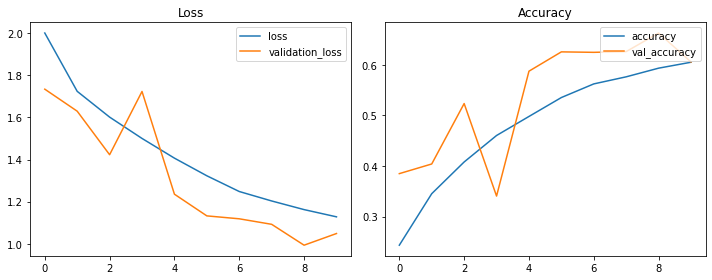

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axes[0].plot(learnHistCNN.history['loss'], label="loss")
axes[0].plot(learnHistCNN.history['val_loss'], label="validation_loss")
axes[0].title.set_text('Loss')
axes[0].legend(loc="upper right")

axes[1].plot(learnHistCNN.history['accuracy'], label="accuracy")
axes[1].plot(learnHistCNN.history['val_accuracy'], label="val_accuracy")
axes[1].title.set_text('Accuracy')
axes[1].legend(loc="upper right")

fig.tight_layout()

169/169 [==============================] - 1s 5ms/step


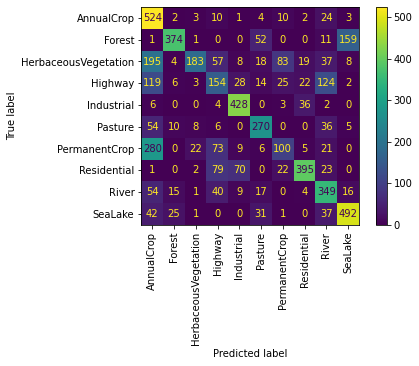

In [18]:
preds = cnnModel.predict(X_test_rescaled)
class_labels = np.argmax(preds, axis=1)

a = ConfusionMatrixDisplay.from_predictions(y_test, 
                                            class_labels, 
                                            display_labels=info.features["label"].names, 
                                            xticks_rotation='vertical')

### CNN (more advanced)

In [ ]:
# Advanced CNN
def getAdvancedCNNModel(
    input_shape = (64, 64, 3),
    nb_filters_one = 32,
    nb_filters_two = 64,
    nb_conv = 3,
    nb_pool = 2,
    dense_size = 128
):
    
    cnnModel = Sequential()
    cnnModel.add(Conv2D(nb_filters_one, kernel_size=(nb_conv, nb_conv),
                     activation='relu',
                     input_shape=input_shape)) # convolutional layer
    cnnModel.add(AveragePooling2D(pool_size=(nb_pool, nb_pool))) # max pooling layer
    cnnModel.add(Dropout(0.25))
    cnnModel.add(Flatten())
    cnnModel.add(Dense(dense_size, activation='relu')) # dense layer
    cnnModel.add(Dropout(0.5))
    cnnModel.add(Dense(nb_classes, activation='softmax'))

    cnnModel.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])
    return cnnModel

cnnModelAdv = getAdvancedCNNModel()
cnnModelAdv.summary()

### ResNet (transfer learning)

In [ ]:
# res = cv2.resize(X_test_rescaled[0], dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
# res.shape

def getResNet50():
    nb_classes = 10
    dense_size = 128

    base_model = ResNet50(weights = 'imagenet', include_top = False, input_shape = (64,64,3), pooling='avg')

    for layer in base_model.layers:
        layer.trainable = False

    x = Flatten()(base_model.output)
    x = Dense(dense_size, activation='relu')(x)
    x = (Dropout(0.5))(x)
    predictions = Dense(nb_classes, activation = 'softmax')(x)

    head_model = Model(inputs = base_model.input, outputs = predictions)

    head_model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])

    return head_model

In [ ]:
resnetmodel = getResNet50()
# resnetmodel.summary()

In [23]:
batch_size = 32
numEpochs = 4

historyRes = resnetmodel.fit(X_train_complete, oneHotLabelTrain, batch_size=batch_size, epochs=numEpochs, 
                         validation_data=(X_test, oneHotLabelTest))

Epoch 1/4
675/675 [==============================] - 19s 22ms/step - loss: 0.6527 - accuracy: 0.7966 - val_loss: 0.3222 - val_accuracy: 0.8935
Epoch 2/4
675/675 [==============================] - 13s 19ms/step - loss: 0.3919 - accuracy: 0.8700 - val_loss: 0.2676 - val_accuracy: 0.9120
Epoch 3/4
675/675 [==============================] - 13s 19ms/step - loss: 0.3270 - accuracy: 0.8933 - val_loss: 0.2584 - val_accuracy: 0.9154
Epoch 4/4
675/675 [==============================] - 13s 19ms/step - loss: 0.2923 - accuracy: 0.9020 - val_loss: 0.2419 - val_accuracy: 0.9183


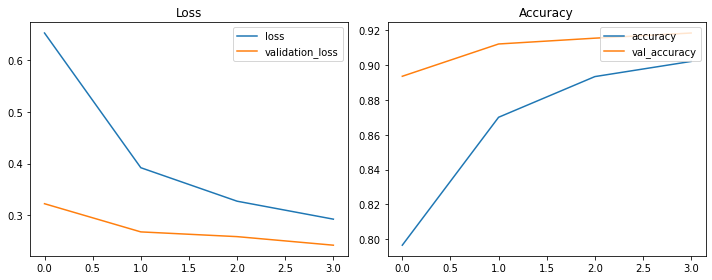

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axes[0].plot(historyRes.history['loss'], label="loss")
axes[0].plot(historyRes.history['val_loss'], label="validation_loss")
axes[0].title.set_text('Loss')
axes[0].legend(loc="upper right")

axes[1].plot(historyRes.history['accuracy'], label="accuracy")
axes[1].plot(historyRes.history['val_accuracy'], label="val_accuracy")
axes[1].title.set_text('Accuracy')
axes[1].legend(loc="upper right")

fig.tight_layout()

In [25]:
preds = resnetmodel.predict(X_test)
class_labels = np.argmax(preds, axis=1)

a = ConfusionMatrixDisplay.from_predictions(y_test, 
                                            class_labels, 
                                            display_labels=info.features["label"].names, 
                                            xticks_rotation='vertical')

169/169 [==============================] - 3s 14ms/step
Error in callback <function flush_figures at 0x7fd7b42d08b0> (for post_execute):


KeyboardInterrupt: ignored


## Experiments

In [26]:
# !pip install keras-tuner --upgrade

from keras_tuner import RandomSearch

def getHyperparameterBaselineCNNModel(hp):
    nb_filters_one = 32,
    nb_filters_two = 64,

    # hyperparameters
    nb_conv = hp.Int('nb_conv', min_value=3, max_value=7, step=2)
    dense_size = hp.Int('dense_size', min_value=32, max_value=128, step=16)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    cnnModel = Sequential()
    cnnModel.add(Conv2D(32, kernel_size=(nb_conv, nb_conv), activation='relu', input_shape=(64, 64, 3))) # convolutional layer
    cnnModel.add(MaxPooling2D(pool_size=(2, 2))) # max pooling layer
    cnnModel.add(Dropout(0.25))
    cnnModel.add(Flatten())
    cnnModel.add(Dense(dense_size, activation='relu')) # dense layer
    cnnModel.add(Dropout(0.5))
    cnnModel.add(Dense(nb_classes, activation='softmax'))

    cnnModel.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=hp_learning_rate), metrics=['accuracy'])

    return cnnModel

# creae randomsearch object
tuner = RandomSearch(hypermodel=getHyperparameterBaselineCNNModel,
                    objective = 'val_accuracy',
                    max_trials = 10)

# search for best parameter
tuner.search(X_train_rescaled,
             oneHotLabelTrain, 
             epochs=4, 
             validation_data=(X_test_rescaled,oneHotLabelTest),
             seed=42)

In [27]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("dense_size", best_hps.get('dense_size'))
print("nb_conv", best_hps.get('nb_conv'))
print("learning_rate", best_hps.get('learning_rate'))

dense_size 112
nb_conv 7
learning_rate 0.01


In [28]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
modelHyper = tuner.hypermodel.build(best_hps)
historyHP = modelHyper.fit(X_train_rescaled, oneHotLabelTrain, epochs=10, validation_split=0.2)


Epoch 1/10
540/540 [==============================] - 5s 8ms/step - loss: 1.9227 - accuracy: 0.2633 - val_loss: 1.7143 - val_accuracy: 0.3495
Epoch 2/10
540/540 [==============================] - 3s 6ms/step - loss: 1.6913 - accuracy: 0.3527 - val_loss: 1.5155 - val_accuracy: 0.5039
Epoch 3/10
540/540 [==============================] - 4s 7ms/step - loss: 1.5388 - accuracy: 0.4320 - val_loss: 1.3160 - val_accuracy: 0.5507
Epoch 4/10
540/540 [==============================] - 3s 6ms/step - loss: 1.4177 - accuracy: 0.4886 - val_loss: 1.3132 - val_accuracy: 0.5650
Epoch 5/10
540/540 [==============================] - 3s 6ms/step - loss: 1.3206 - accuracy: 0.5292 - val_loss: 1.1778 - val_accuracy: 0.6102
Epoch 6/10
540/540 [==============================] - 3s 6ms/step - loss: 1.2494 - accuracy: 0.5608 - val_loss: 1.0965 - val_accuracy: 0.6199
Epoch 7/10
540/540 [==============================] - 3s 6ms/step - loss: 1.1772 - accuracy: 0.5844 - val_loss: 1.2370 - val_accuracy: 0.5373
Epoch 

KeyboardInterrupt: ignored

In [ ]:
axes[0].plot(historyHP.history['loss'], label="loss")
axes[0].plot(historyHP.history['val_loss'], label="validation_loss")
axes[0].title.set_text('Loss')
axes[0].legend(loc="upper right")

axes[1].plot(historyHP.history['accuracy'], label="accuracy")
axes[1].plot(historyHP.history['val_accuracy'], label="val_accuracy")
axes[1].title.set_text('Accuracy')
axes[1].legend(loc="upper right")

fig.tight_layout()

In [ ]:
preds = model.predict(X_test_rescaled)
class_labels = np.argmax(preds, axis=1)

a = ConfusionMatrixDisplay.from_predictions(y_test, 
                                            class_labels, 
                                            display_labels=info.features["label"].names, 
                                            xticks_rotation='vertical')

## Conclusions

In [ ]:
# Comparison of models


# results + interpretation

# Comparing Loss and Accuracy of all models

# Future Tests: Vision Transformers (see Dosovitskiy, A., Beyer, L., Kolesnikov, A., Weissenborn, D., Zhai, X., Unterthiner, T., ... & Houlsby, N. (2020). An image is worth 16x16 words: Transformers for image recognition at scale. arXiv preprint arXiv:2010.11929)
# Autoencoder also possible but not the best option
# - Vision Transformers https://keras.io/examples/vision/image_classification_with_vision_transformer/